In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, execute

from qiskit.visualization import plot_histogram

In [9]:
def example_grover_iteration():
    qc = QuantumCircuit(4)
    
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc


In [10]:
grit = example_grover_iteration().to_gate()
cgrit = grit.control()
cgrit.label = "Grover"


In [11]:
def qft(n):
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n - qubit - 1)
        return circuit
    
    def qft_rotations(circuit, n):
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [12]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"



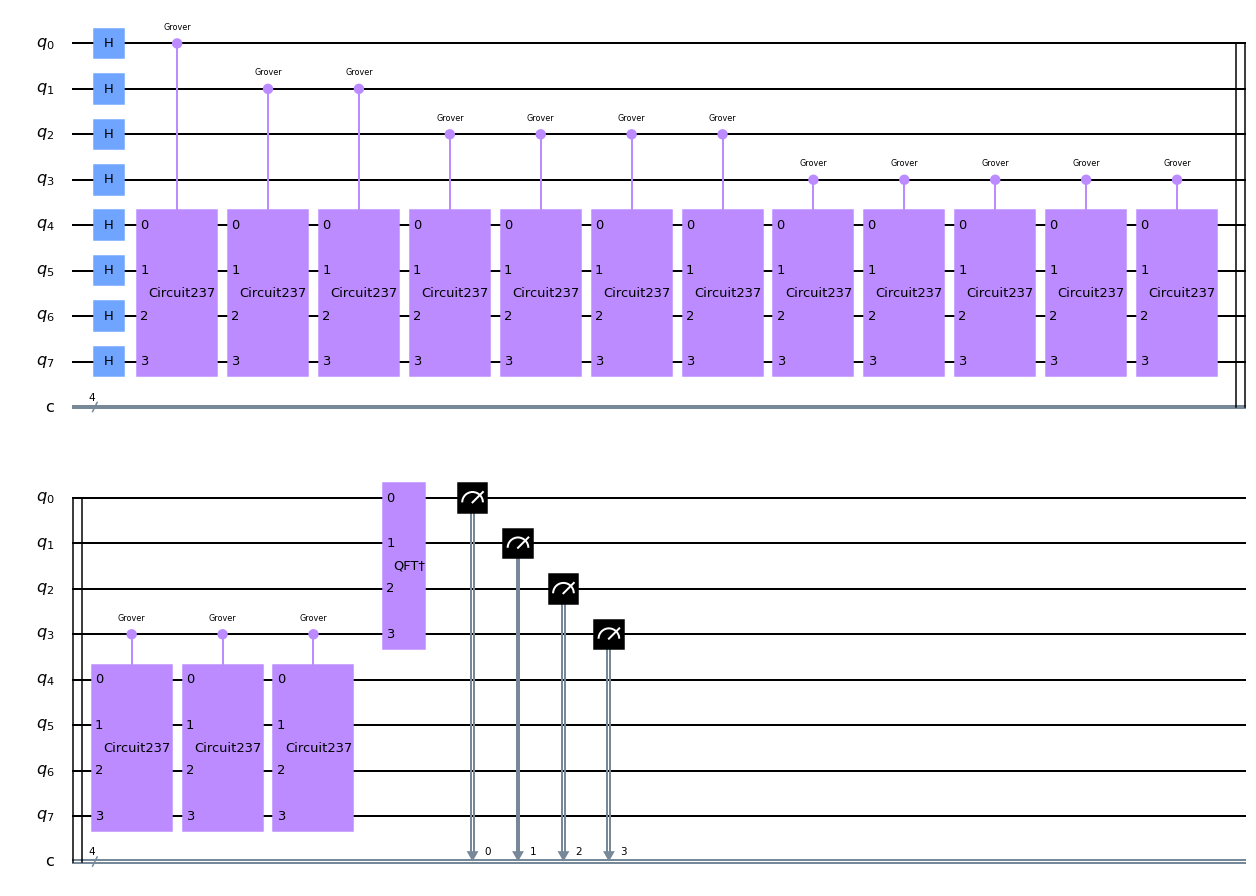

In [13]:
t = 4 
n = 4
qc = QuantumCircuit(n +t, t)

for qubit in range(t+n):
    qc.h(qubit)

iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
qc.append(qft_dagger, range(t))

qc.measure(range(t), range(t))

qc.draw('mpl')


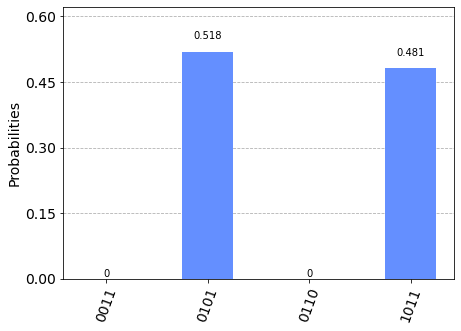

In [14]:
emulator = Aer.get_backend('qasm_simulator')
job = execute(qc, emulator, shots = 2048)
hist = job.result().get_counts()
plot_histogram(hist)

In [15]:
measured_str = max(hist, key=hist.get)


In [16]:
measured_int = int(measured_str, 2)
print("register output = %i" % measured_int)


register output = 5


In [18]:
theta = (measured_int/(2**t))*math.pi*2
print("theta = %0.5f" %theta)

theta = 1.96350


In [19]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9


In [21]:
m = t - 1
err = (math.sqrt(2*M*N) + N/ (2**(m - 1)))*(2**(-m))
print("error < %.2f" %err)

error < 2.85


In [22]:
def calculate_M(measured_int, t, n):
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    m = t - 1
    err = (math.sqrt(2*M*N) + N / (2**(m -1)))*(2**(-m))
    print("error < %.2f" % err)

In [23]:
calculate_M(measured_int, t, n)


Theta = 1.96350
No. of Solutions = 4.9
error < 2.85


In [24]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.9.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.21.0'}